In [1]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, roc_auc_score, accuracy_score, recall_score
from tabpfn import TabPFNRegressor
import huggingface_hub
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()
huggingface_hub.login(token=os.getenv("HF_TOKEN"))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [9]:
data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
data_df = pd.read_csv(data_path)

In [10]:
features_to_exclude = ['tsunami', 'Year', 'Month','month_number','dmin','nst','longitude','latitude']
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [11]:
regressor = TabPFNRegressor(device=device)
regressor.fit(X_train.values, y_train.values)

,n_estimators,8
,categorical_features_indices,None
,softmax_temperature,0.9
,average_before_softmax,False
,model_path,'auto'
,device,'cuda'
,ignore_pretraining_limits,False
,inference_precision,'auto'
,fit_mode,'fit_preprocessors'
,memory_saving_mode,'auto'
,random_state,0


In [12]:
baseline_threshold = 0.0383
reg_scores_test = regressor.predict(X_test)
baseline_preds = (reg_scores_test >= baseline_threshold).astype(int)

c:\Users\ASUS\Desktop\Coding\CanProjects\TsunamiRiskAssessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but TabPFNRegressor was fitted without feature names
  warnings.warn(


In [13]:
baseline_recall = recall_score(y_test, baseline_preds)
baseline_f2 = fbeta_score(y_test, baseline_preds, beta=2.0)
baseline_accuracy = accuracy_score(y_test, baseline_preds)

In [14]:
baseline_recall

0.9629629629629629

In [15]:
baseline_f2

0.7942973523421588

In [16]:
baseline_accuracy

0.7371428571428571

In [17]:
def f2_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2.0)

In [18]:
def score_with_threshold(estimator, X, y, threshold=baseline_threshold):
    scores = estimator.predict(X)
    preds = (scores >= threshold).astype(int)
    return f2_scorer(y, preds)

In [19]:
perm_importance = permutation_importance(
    regressor, 
    X_test.values, 
    y_test.values,
    scoring=score_with_threshold,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

In [20]:
perm_results = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)
perm_results

,feature,importance_mean,importance_std
5,distance_to_coast_km,0.117583,0.027765
0,magnitude,0.102412,0.018746
4,depth,0.080476,0.008920
3,sig,0.068292,0.010963
1,cdi,0.032271,0.008404
6,gap,0.025288,0.010661
2,mmi,0.006165,0.004567


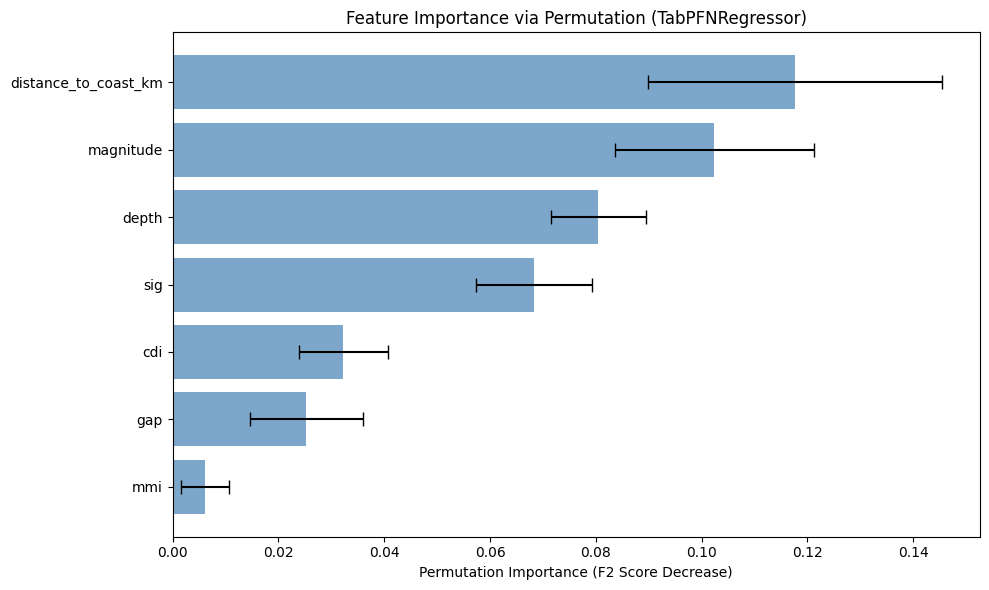

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(perm_results))
ax.barh(y_pos, perm_results['importance_mean'], xerr=perm_results['importance_std'], 
        capsize=5, color='steelblue', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(perm_results['feature'])
ax.set_xlabel('Permutation Importance (F2 Score Decrease)')
ax.set_title('Feature Importance via Permutation (TabPFNRegressor)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [25]:
# Feature ablation: Remove one feature at a time and measure performance drop
ablation_results = []

for feature in X.columns:
    # Remove feature
    X_train_ablated = X_train.drop(columns=[feature])
    X_test_ablated = X_test.drop(columns=[feature])
    
    # Train model without this feature
    reg_ablated = TabPFNRegressor()
    reg_ablated.fit(X_train_ablated.values, y_train.values)
    
    # Predict with same threshold
    scores_ablated = reg_ablated.predict(X_test_ablated.values)
    preds_ablated = (scores_ablated >= baseline_threshold).astype(int)
    
    # Calculate metrics
    recall_ablated = recall_score(y_test, preds_ablated)
    f2_ablated = fbeta_score(y_test, preds_ablated, beta=2.0)
    accuracy_ablated = accuracy_score(y_test, preds_ablated)
    
    # Performance drop
    recall_drop = baseline_recall - recall_ablated
    f2_drop = baseline_f2 - f2_ablated
    accuracy_drop = baseline_accuracy - accuracy_ablated
    
    ablation_results.append({
        'feature': feature,
        'recall_drop': recall_drop,
        'f2_drop': f2_drop,
        'accuracy_drop': accuracy_drop,
        'recall_without': recall_ablated,
        'f2_without': f2_ablated,
        'accuracy_without': accuracy_ablated
    })

ablation_df = pd.DataFrame(ablation_results).sort_values('f2_drop', ascending=False)
ablation_df

,feature,recall_drop,f2_drop,accuracy_drop,recall_without,f2_without,accuracy_without
4,depth,0.074074,0.075734,0.062857,0.888889,0.718563,0.674286
5,distance_to_coast_km,0.061728,0.049399,0.025714,0.901235,0.744898,0.711429
1,cdi,0.049383,0.040733,0.022857,0.913580,0.753564,0.714286
0,magnitude,0.037037,0.036722,0.028571,0.925926,0.757576,0.708571
3,sig,0.012346,0.016520,0.017143,0.950617,0.777778,0.720000
2,mmi,0.000000,0.008007,0.014286,0.962963,0.786290,0.722857
6,gap,0.000000,0.003222,0.005714,0.962963,0.791075,0.731429


### I think every feature of us have an impact in our results even if its minimal. So we dont need to remove anymore feature